## MCMC 的秘诀

PyMC 提供了贝叶斯推断的一个强大后台，它能够很好的向用户隐藏 MCMC 等算法的内部实现机制。尽管如此，为了确保估计不会因为 MCMC 算法天然的迭代性而导致偏差，我们还需要注意一些细节，下面的实验中，我们会详细的阐述，这些我们需要注意的细节。

- 子相关性
- 稀释
- MCMC的初始值的选取
- 先验的选择


我们将序列 $x_t$ 在 $t$ 时刻与 $t-k$ 时刻的相关性，定义为：
$$R(k) = Corr( x_t, x_{t-k} ) $$

一种更容易理解自相关性的方式是，如果我拥有 $x_t$ 序列的前 $t - k$ 个数据，我能够很容易估计序列在 t 时刻的值，那么就可以说该序列在 $t$ 时刻 与 $t -k$ 时刻具有相关性。因此可以说，序列 $x$ 是自相关的。

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

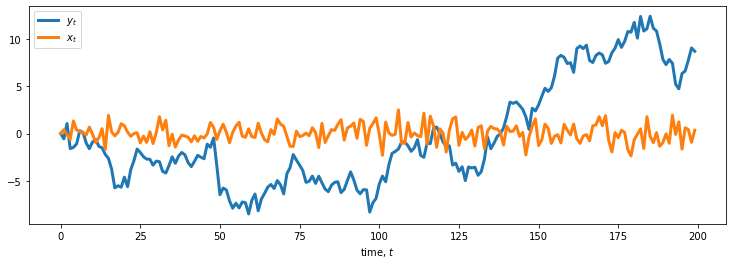

In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 4)
# 生成 x 序列
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0

# 生成 y 序列
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend()

In [2]:
def autocorr(x):
        # 求取自相关
        result = np.correlate(x, x, mode='full')
        # 结果进行归一化
        result = result / np.max(result)
        # 由于correlate 本身是求取两个不同序列的相关系数
        # 因此，reslut 会存储： [第一个x与第二个x 的相关系数序列,第二个x与第一个x 的相关系数序列]
        # 因此这里我们result 序列的一半即可
        return result[result.size // 2:]


result = autocorr(x_t)
print("x 序列的长度：", len(x_t))
print("result 序列的长度：", len(result))

x 序列的长度： 200
result 序列的长度： 200


Text(0.5, 1.0, 'Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.')

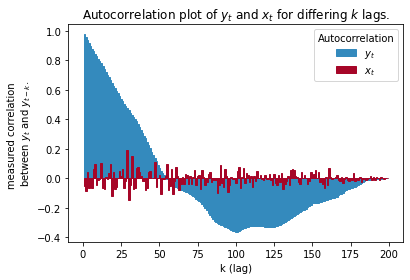

In [3]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
# 横坐标，表示第 i 条数据
x = np.arange(1, 200)
# 得到 y_t 序列的自相关序列
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
# 得到 x_t 序列的自相关序列
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.")

Text(0.5, 1.0, 'Autocorrelation of $y_t$ (no thinning vs. thinning) at differing $k$ lags.')

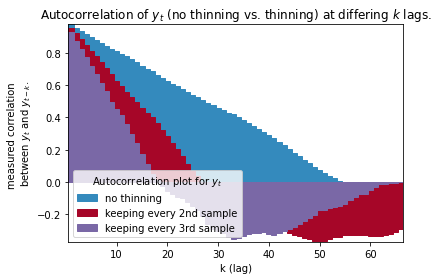

In [4]:
# 指定序列的个数
# 我们间隔分别 1， 2,3取三个长度为 max_x 的序列
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

# 画出间隔1 的序列，即原序列。共 max_x 条数据
plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)

# 每间隔 2 取一个数据。共 max_x 条数据
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
# 每间隔 3 取一个数据。共 max_x 条数据
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.")

如上图所示，增加稀释程度可以更快的减少相关性。但并不是说间隔越大越好，因为稀释程度的增加意味着需要进行更多的 MCMC 迭代才能保持同样的样本量。比如 10 000 个未稀释的样本相当于100 000 个以 10 为间隔进行稀释的样本（即使后者的相关性较小，更适合用于后面的处理，但是计算量太大）。

那么稀释程度以多少为宜呢？由于不论如何稀释，返回的样本都会存在一定的相关性，因此只需要稀释到自相关性快速趋近于 0 的位置即可。一般来说，最后确定的间隔不会超过 10。


如果，不是 MCMC 的计算复杂度不大，贝叶斯推断早就是一个应用非常广泛的方法了。可以说 MCMC 是导致很多用户放弃使用贝叶斯推断的主要原因。接下来，我们会提供一些启发式的方法来加速 MCMC 引擎并帮助它更快的收敛。

#### 较好的初始值

如果能够让 MCMC 算法以后验分布的附近位置为起点，那么就有利于算法在很短的时间内就能得到有效的采样。我们可以使用 value 参数来告诉算法，我们猜测的后验分布会在哪里。代码格式如下：


$$mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )$$

当然，我们也可以用上一个试验提到的 `findMap` 来让计算机自己去估算一个较好的初始值，但是计算机估算的过程也需要一定的时间。因此提供一个用户自定义的初值是很有必要的。